In [63]:
import os
import time
import pickle
import pandas as pd
import numpy as np

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import random
random.seed(1333)

from dotenv import load_dotenv
load_dotenv()

True

In [64]:
cid = os.environ["SPOTIFY_CID"]
secret = os.environ["SPOTIFY_SECRET"]   
username = os.environ["SPOTIFY_USERNAME"]   
scope = 'user-library-read playlist-modify-public playlist-read-private user-read-currently-playing user-read-recently-played user-top-read'
redirect_uri = 'http://localhost:8000/connect'

token = util.prompt_for_user_token(username, scope, cid, secret, redirect_uri)
sp = spotipy.Spotify(auth=token)

In [65]:
f = open("songs.pkl","rb")
songs = pickle.load(f)

songs.sample(3)

,playlist_id,track_id,track_name,track_popularity,playlist_name,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
1368,5BygwTQ3OrbiwVsQhXFHMz,44M6Wd0vAzN9khoCQSR6ji,Where The Streets Have No Name - Single Edit,0,Classic Rock,rock,classic rock,0.504,0.857,2.0,-6.014,1.0,0.0379,0.011900,0.006530,0.1300,0.354,125.636,276132.0,4.0
1166,37i9dQZF1DX49jUV2NfGku,3SUusuA9jH1v6PVwtYMbdv,Last Nite,64,Rock Solid,rock,rock,0.624,0.899,0.0,-5.710,1.0,0.0295,0.022300,0.000155,0.0975,0.797,104.055,193373.0,4.0
1125,37i9dQZF1DX49jUV2NfGku,4VqPOruhp5EdPBeR92t6lQ,Uprising,75,Rock Solid,rock,rock,0.602,0.905,2.0,-4.046,1.0,0.0775,0.000202,0.064000,0.1170,0.411,128.019,304840.0,4.0


In [66]:
songs.dropna(axis=0,how="any",inplace=True)

In [67]:
songs = songs[songs["duration_ms"] < 0.5*10**6]


# training the classification models

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler , MinMaxScaler

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, precision_recall_curve,f1_score

from graphviz import Source
from IPython.display import Image  
import pydotplus

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier , plot_tree , export_graphviz
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

from sklearn.pipeline import Pipeline


### dropping the irrelevant columns

In [69]:
# dropping the irrelavent columns for training the model
data = songs.drop(["playlist_id","track_id","track_name","playlist_name","playlist_subgenre","track_popularity"],axis=1)

### X,y, features, classes and train test split

In [70]:
y = data["playlist_genre"]
X = data.drop(["playlist_genre"],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

feature_names = X.columns
classes = y_test.unique()

In [71]:
feature_names

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature'],
      dtype='object')

## a function for caluclating metrics

In [72]:
def build_metrics(model,X_test,y_test,classes):
    accuracy = cross_val_score(model, X_test, y_test, cv=10)
    p = precision_score(y_test, model.predict(X_test), average=None,labels=classes)
    r = recall_score(y_test, model.predict(X_test), average=None,labels=classes)
    f1 = f1_score(y_test, model.predict(X_test), average=None,labels=classes)
    metrics = pd.DataFrame([p,r,f1], index= ['precision','recall','f1'], columns=classes)
    return np.mean(accuracy), metrics


# Training multiple models and comparing the metrics
## Decision tree

In [73]:
scaler = MinMaxScaler()
pca = PCA()
dt = DecisionTreeClassifier(random_state=0)

pipe = Pipeline(steps=[('scaler', scaler),
                       ('pca', pca),
                       ('dt', dt)])


n_components = list(range(1,X.shape[1]+1,1))
criterion = ['gini', 'entropy']
max_depth = np.arange(3, 10)

params = dict(pca__n_components=n_components,
              dt__criterion=criterion,
              dt__max_depth=max_depth)


dt_grid = GridSearchCV(pipe, params)
dt_grid.fit(X_train,y_train)

dt_grid.best_params_


{'dt__criterion': 'entropy', 'dt__max_depth': 7, 'pca__n_components': 12}

In [74]:
accuracy, metrics = build_metrics(dt_grid,X_test,y_test,classes)
print("Decision Tree Accuracy: ",accuracy)
display(metrics)


Decision Tree Accuracy:  0.47562189054726367


,rock,hip hop,pop,latin,edm,metal
precision,0.453125,0.699115,0.350427,0.457143,0.500000,0.518519
recall,0.495726,0.752381,0.372727,0.413793,0.344086,0.578512
f1,0.473469,0.724771,0.361233,0.434389,0.407643,0.546875


## Confusion matrix of our Decision Tree

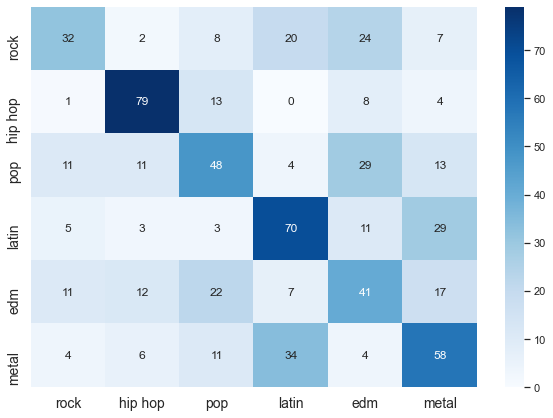

In [75]:
conf_matrix =  confusion_matrix(y_test, dt_grid.predict(X_test));
plt.figure(figsize=(10,7))
plt.xticks(size=14)
plt.yticks(size=14, rotation=45)
sns.heatmap(conf_matrix, cmap='Blues',annot=True ,xticklabels=classes, yticklabels=classes);

## Drawing the decision tree with best params

In [39]:
dt = DecisionTreeClassifier(criterion="gini",max_depth=7)
dt.fit(X_train,y_train)

dot_data = export_graphviz(dt, out_file=None, 
                            feature_names=feature_names,  
                            class_names=classes)

graph = Source(dot_data)
png_bytes = graph.pipe(format='png')
with open('spotify_decision_tree.png','wb') as f:
    f.write(png_bytes)
    
# Image(png_bytes)


## Random Forest

In [76]:
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train,y_train)

accuracy, metrics = build_metrics(forest,X_test,y_test,classes)
print("Random Forest Accuracy: ",accuracy)
display(metrics)

Random Forest Accuracy:  0.6344866576209861


,rock,hip hop,pop,latin,edm,metal
precision,0.727273,0.741667,0.454545,0.571429,0.670588,0.762295
recall,0.683761,0.847619,0.409091,0.620690,0.612903,0.768595
f1,0.704846,0.791111,0.430622,0.595041,0.640449,0.765432


## confusion matrix of our random forest model

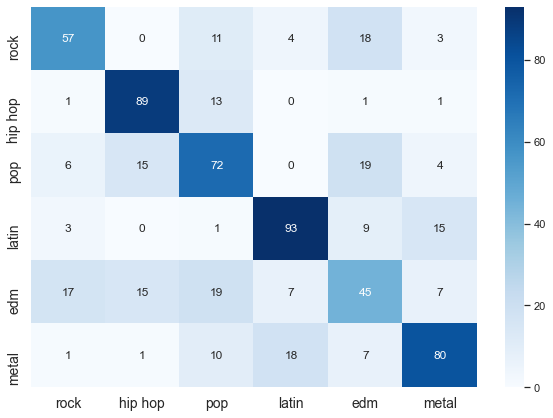

In [81]:
conf_matrix =  confusion_matrix(y_test, forest.predict(X_test));
plt.figure(figsize=(10,7))
plt.xticks(size=14)
plt.yticks(size=14, rotation=45)
sns.heatmap(conf_matrix, cmap='Blues',annot=True ,xticklabels=classes, yticklabels=classes);

### Random Forest Confused about "edm" and "pop"

In [78]:
Confusion_X_test = X_test.copy()
Confusion_X_test["true_genres"] = y_test.values
Confusion_X_test["forest_predictions"] = forest.predict(X_test)

confused = Confusion_X_test[ (Confusion_X_test["forest_predictions"] == "pop") &
                  (Confusion_X_test["true_genres"] == "edm")
                ]

confused = confused.merge(songs[["track_name"]],left_index=True,right_index=True)[["track_name","true_genres","forest_predictions"]]
confused


,track_name,true_genres,forest_predictions
2225,Move - Showtek Radio Edit,edm,pop
1884,Call You Mine (feat. Bebe Rexha) - Keanu Silva...,edm,pop
1908,Don't Start Now,edm,pop
1765,Lost,edm,pop
1934,Back Around,edm,pop
1832,Sixteen - Don Diablo Remix,edm,pop
2020,I Follow Rivers - The Magician Remix,edm,pop
1793,Take Me Away,edm,pop
1751,Coming Home,edm,pop
1759,Lose It All,edm,pop


## Importance of features for Random Forest

<AxesSubplot:ylabel='0'>

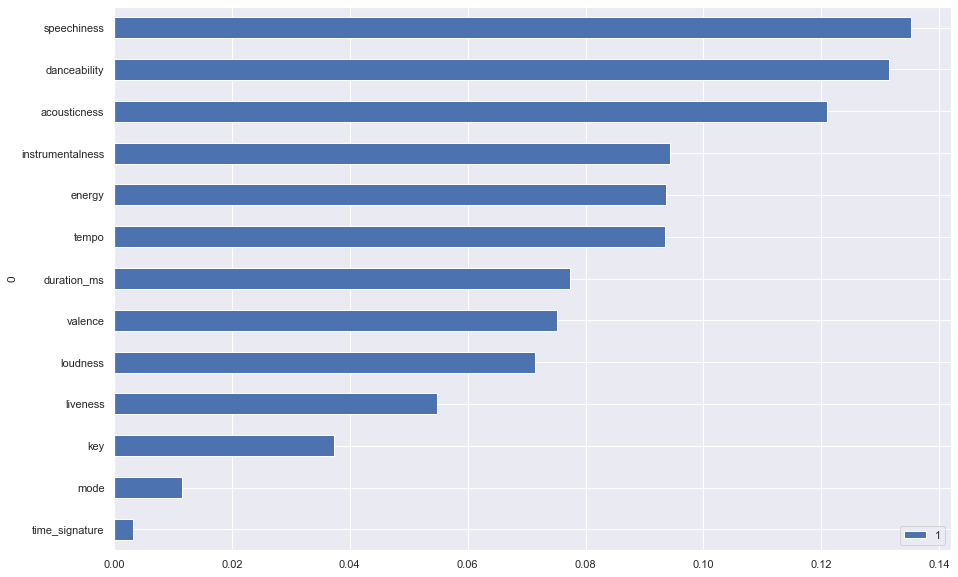

In [83]:
fig,ax = plt.subplots(1,figsize=(15,10))

feature_importances = pd.DataFrame(zip(X.columns, forest.feature_importances_))
feature_importances.set_index(0,inplace=True)
feature_importances.sort_values(1,ascending=True,inplace=True)
feature_importances.plot.barh(ax=ax)

## Looping over different models, searching for best accuracies
Instead of fitting sklearn models one by one it would be nice to first loop over all of them and see what we get. The credit for this beautiful helper goes to david batista. It's very useful for trying our different models quickly, and see how each one is doing. I added a scaler and pipeline to the fit method.

In [84]:
class ModelSelection:
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError(f"Some estimators are missing parameters: {missing_params}" )
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"Running GridSearchCV for {key}.")
            model = self.models[key]
            params = self.params[key]
            scaler = MinMaxScaler()
#             scaler = StandardScaler()
            pipe = Pipeline(steps=[('scaler', scaler),
                                   (key, model)])

            gs = GridSearchCV(pipe, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = f"split{i}_test_score"
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [85]:

models1 = {
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'LogisticRegression':LogisticRegression(),
    'SVC': SVC(),
    'AdaBoostClassifier':AdaBoostClassifier(),
    'KNeighborsClassifier':KNeighborsClassifier()
}

params1 = {
    'RandomForestClassifier': { 'RandomForestClassifier__n_estimators': [16, 32],"RandomForestClassifier__max_depth" : np.arange(3, 10) },
    'GradientBoostingClassifier': { 'GradientBoostingClassifier__n_estimators': [16, 32], 'GradientBoostingClassifier__learning_rate': [0.8, 1.0] },
    'LogisticRegression':{'LogisticRegression__penalty':["l2"], 'LogisticRegression__multi_class':['auto'],'LogisticRegression__max_iter':[1000]},
    'SVC': [{'SVC__kernel': ['rbf'], 'SVC__C': [1, 10], 'SVC__gamma': [0.001, 0.0001]},],
    'AdaBoostClassifier':  { 'AdaBoostClassifier__n_estimators': [16, 32] },
    'KNeighborsClassifier': {"KNeighborsClassifier__n_neighbors":[5]}
    
}

In [86]:
discovery = ModelSelection(models1, params1)
discovery.fit(X_train, y_train, scoring='f1_micro', n_jobs=4)


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 out of  42 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    9.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Running GridSearchCV for LogisticRegression.
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Running GridSearchCV for SVC.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Running GridSearchCV for KNeighborsClassifier.
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    0.4s finished


In [88]:
# discovery
discovery.score_summary(sort_by='mean_score')


RandomForestClassifier
GradientBoostingClassifier
LogisticRegression
SVC
AdaBoostClassifier
KNeighborsClassifier


,estimator,min_score,mean_score,max_score,std_score,RandomForestClassifier__max_depth,RandomForestClassifier__n_estimators,GradientBoostingClassifier__learning_rate,GradientBoostingClassifier__n_estimators,LogisticRegression__max_iter,LogisticRegression__multi_class,LogisticRegression__penalty,SVC__C,SVC__gamma,SVC__kernel,AdaBoostClassifier__n_estimators,KNeighborsClassifier__n_neighbors
13,RandomForestClassifier,0.62585,0.63255,0.639864,0.00573753,9,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,RandomForestClassifier,0.620612,0.63255,0.651189,0.013352,8,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,RandomForestClassifier,0.622877,0.629154,0.636467,0.00559624,9,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,RandomForestClassifier,0.60771,0.620463,0.642129,0.0154,8,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,RandomForestClassifier,0.616082,0.619334,0.625142,0.00411619,7,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,GradientBoostingClassifier,0.608844,0.618199,0.634202,0.0113695,NaN,NaN,0.8,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,RandomForestClassifier,0.613817,0.617072,0.622449,0.00383045,7,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,RandomForestClassifier,0.606576,0.611026,0.613817,0.00318009,6,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,GradientBoostingClassifier,0.597961,0.608007,0.616082,0.00752756,NaN,NaN,0.8,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,GradientBoostingClassifier,0.594564,0.606495,0.620612,0.0107457,NaN,NaN,1,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## training OneVsRestClassifier

In [89]:
OneVsRest = OneVsRestClassifier(RandomForestClassifier(random_state=0))
OneVsRest.fit(X_train,y_train)

accuracy, metrics = build_metrics(OneVsRest,X_test,y_test,classes)
print("OneVsRest Accuracy: ",accuracy)
display(metrics)

OneVsRest Accuracy:  0.6480777928539122


,rock,hip hop,pop,latin,edm,metal
precision,0.655172,0.769912,0.528090,0.544000,0.650000,0.773109
recall,0.649573,0.828571,0.427273,0.586207,0.698925,0.760331
f1,0.652361,0.798165,0.472362,0.564315,0.673575,0.766667


## How are our models doing compared to baseline?
### a random choice as our baseline
our best accuracy score was %75 which is doing much better than the baseline

In [105]:
baseline_y_predicitons = pd.Series([random.choice(classes) for _ in range(y_test.shape[0]) ])

correct_predictions = (baseline_y_predicitons.reset_index(drop=True) == y_test.reset_index(drop=True)).sum()
baseline_accuracy = "%.2f"%(correct_predictions / y_test.shape[0])
baseline_accuracy

'0.18'

In [102]:
classes

array(['rock', 'hip hop', 'pop', 'latin', 'edm', 'metal'], dtype=object)